In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import fashion_mnist
import torch
import torch.nn.functional as F
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
import torchvision
from torchvision import transforms as T
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.metrics import classification_report,  confusion_matrix, ConfusionMatrixDisplay
from custom_transformers import *
from augmentation_generator_batch_size import *

In [4]:
def seed_everything(seed: int=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(51)

# Load data

In [7]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

# Konwersja do RGB
X_train = np.repeat(X_train, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

# One-hot
Y_train = to_categorical(Y_train.flatten())
Y_test = to_categorical(Y_test.flatten())

k = Y_train.shape[1]

print(f"X_train.shape: {X_train.shape} \nY_train.shape: {Y_train.shape} \nX_test.shape: {X_test.shape} \nY_test.shape: {Y_test.shape}")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
X_train.shape: (60000, 28, 28, 3) 
Y_train.shape: (60000, 10) 
X_test.shape: (10000, 28, 28, 3) 
Y_test.shape: (10000, 10)


# CNN Random Square Cutout, max_ratio = 0.05, max_squares = 10, with soft labeling

In [9]:
square_cutout = RandomSquaresCutout(max_size_ratio = 0.05, max_number_of_squares = 10)

train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor = square_cutout, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=True)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

In [10]:
k = Y_train.shape[1]
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.2)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

In [11]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
  train_generator, validation_data=test_generator, epochs=6)

Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 705s 309ms/step - accuracy: 0.8131 - loss: 0.5723 - val_accuracy: 0.8719 - val_loss: 0.3613
Epoch 2/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 697s 310ms/step - accuracy: 0.9008 - loss: 0.2732 - val_accuracy: 0.8955 - val_loss: 0.2832
Epoch 3/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 698s 310ms/step - accuracy: 0.8934 - loss: 0.3706 - val_accuracy: 0.8725 - val_loss: 0.3946
Epoch 4/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 685s 305ms/step - accuracy: 0.8755 - loss: 0.8995 - val_accuracy: 0.8687 - val_loss: 0.6966
Epoch 5/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 672s 299ms/step - accuracy: 0.8587 - loss: 1.4713 - val_accuracy: 0.8568 - val_loss: 2.2961
Epoch 6/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 684s 304ms/step - accuracy: 0.8161 - loss: 9.4185 - val_accuracy: 0.7701 - val_loss: 4.5235


In [12]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(test_generator.y_combined, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 92ms/step


              precision    recall  f1-score   support

           0       0.74      0.79      0.76      1000
           1       0.99      0.92      0.95      1000
           2       0.51      0.69      0.59      1000
           3       0.85      0.73      0.78      1000
           4       0.47      0.59      0.52      1000
           5       0.99      0.93      0.96      1000
           6       0.42      0.25      0.32      1000
           7       0.88      0.98      0.93      1000
           8       0.93      0.90      0.92      1000
           9       0.97      0.93      0.95      1000

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.77      0.77     10000



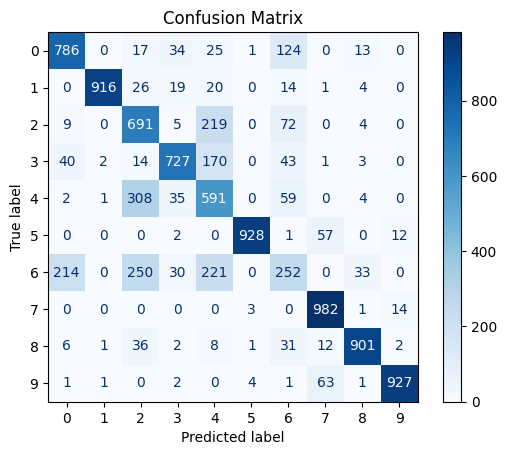

In [13]:
print(classification_report(y_true, y_pred_classes))
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Final Training Accuracy: 0.7879
Final Validation Accuracy: 0.7701


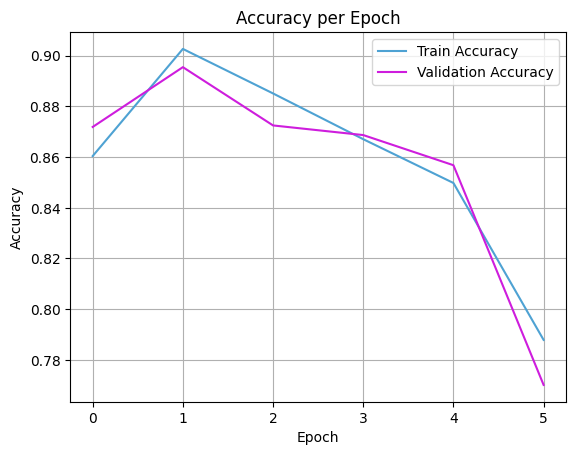

In [14]:
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {r.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()